In [59]:
%matplotlib inline

import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
from scipy import stats
from scipy import optimize

import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')



In [46]:
# Sample R code for "Bayesian Decision Theory Made Ridiculously Simple."
# http://www.statsathome.com/2017/10/12/bayesian-decision-theory-made-ridiculously-simple/
d = pd.DataFrame({'sold':[1, 1, 0, 0, 1, 1], 
                  'scratched': [0, 0, 1, 0, 0, 0], 
                  'year': [4, 5, 0, 4, 5, 6], 
                  'price': [50, 70, 40, 100, 90, 100]})
print(d)



   sold  scratched  year  price
0     1          0     4     50
1     1          0     5     70
2     0          1     0     40
3     0          0     4    100
4     1          0     5     90
5     1          0     6    100


In [49]:
# pymc3
with pm.Model() as logistic_model:
    my_priors = {"Intercept": pm.Normal.dist(mu=0, sd=10000),
                 "scratched": pm.Normal.dist(mu=-1, sd=1),
                 "year": pm.Normal.dist(mu=1, sd=1),
                 "price": pm.Normal.dist(mu=-2, sd=1)
                }
    pm.glm.GLM.from_formula('sold ~ scratched + year + price', d, family=pm.glm.families.Binomial(), priors=my_priors)

    trace_logistic_model = pm.sample(2000, chains=2, tune=1000)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [price, year, scratched, Intercept]
Sampling 2 chains, 2 divergences: 100%|██████████| 6000/6000 [00:07<00:00, 813.16draws/s] 
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [50]:
# Coefficients
for RV in logistic_model.basic_RVs:
    print(RV.name, RV.logp(logistic_model.test_point))

    

Intercept -10.129278905180856
scratched -0.9189385332046727
year -0.9189385332046727
price -0.9189385332046727
y -600.0


In [58]:
df_trace = pm.trace_to_dataframe(trace_logistic_model[niter//2:])

Intercept, scratched, year, price = df_trace.mean(0)
#print(Intercept)

def predict(dd, Intercept=Intercept, scratched=scratched, year=year, price=price):
    v = Intercept + scratched*dd['scratched'] + year*dd['year'] + price*dd['price']
    return np.exp(v)/(1 + np.exp(v))

phone = {'scratched':0, 'year':4, 'price':100}
print(predict(phone))

def loss(price):
    # First Create the input data to predict with out model: 
    # we want to predict whether or not our phone will sell
    phone = {'scratched':0, 'year':4, 'price':price}
    
    # Next, for each posterior sample from out model, 
    # predict whether or not our phone would sell at the given price. 
    # This will give a vector of 0's and 1's, did the phone sell in each posterior sample. 
    # Think of each posterior sample as a simulation.
    pr = predict(phone)
    
    # Next calculate the expected return for each of these posterior simulations
    return pr*price

print(loss(100))



0.2009527415562357
20.095274155623567


In [63]:
# https://www.rdocumentation.org/packages/stats/versions/3.6.1/topics/optim
# 50 is the initial parameter value.
# Nelder-Mead method is the default, which works reasonably well for non-differentiable functions.
rslt = optimize.minimize(lambda x: -loss(x), 50, method='Nelder-Mead')
print(rslt)


 final_simplex: (array([[71.76368713],
       [71.76376343]]), array([-63.5094136, -63.5094136]))
           fun: -63.509413604174696
       message: 'Optimization terminated successfully.'
          nfev: 40
           nit: 20
        status: 0
       success: True
             x: array([71.76368713])


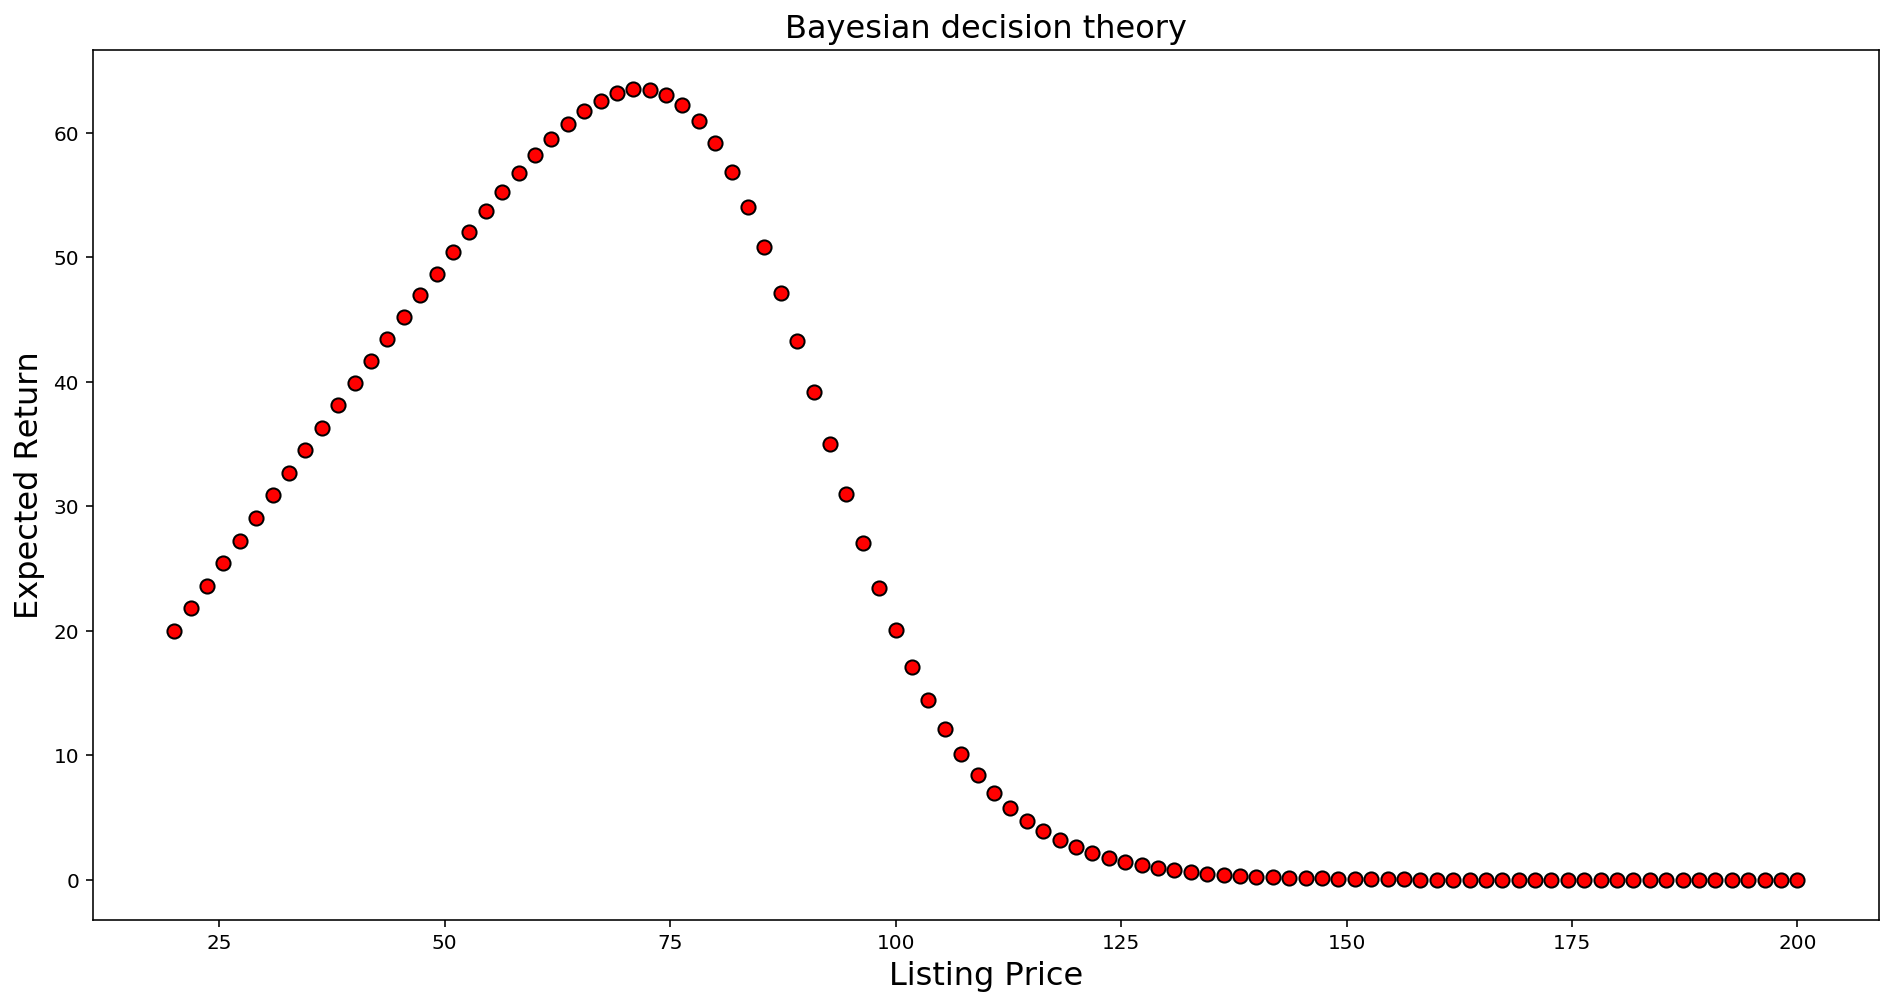

In [66]:
# Expected returns by prices.
X = np.linspace(20, 200, 100)
Y = [loss(x) for x in X]

plt.figure(figsize=(16, 8))
plt.scatter(X, Y, facecolors='red', edgecolors='k', s=50, alpha=1)
plt.xlabel('Listing Price', fontsize=16)
plt.ylabel('Expected Return', fontsize=16)
plt.title('Bayesian decision theory', fontsize=16)

plt.savefig('Bayesian_decision_theory_sample.png')


In [65]:
# Appendix
n = np.ones(d.shape[0])
niter = 200

def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

with pm.Model() as logistic_reg: 
    a = pm.Normal('a', mu=0, sd=10000)  
    b1 = pm.Normal('b1', mu=-1, sd=1)
    b2 = pm.Normal('b2', mu=1, sd=1)
    b3 = pm.Normal('b3', mu=-2, sd=1)
    
    # Expected value
    p = invlogit(a*n + b1*d.scratched + b2*d.year + b3*d.price)

    # Likelihood
    sold = pm.Bernoulli('sold', p=p, observed=d.sold)
    
    trace = pm.sample(niter, random_seed=123)

for RV in logistic_reg.basic_RVs:
    print(RV.name, RV.logp(logistic_reg.test_point))

    

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b3, b2, b1, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 2800/2800 [00:03<00:00, 898.42draws/s] 


a -10.129278905180856
b1 -0.9189385332046727
b2 -0.9189385332046727
b3 -0.9189385332046727
sold -600.0
